# PROPOSED INVESTIGATION: TWITTER SENTIMENTAL ANALYSIS FOR A BIG DATA PROJECT USING PYSPARK AND SPARK MLLIB
                                      DATE: 20 March 2023
                                      COURSE: BIG DATA ANALYSIS MODULE DSM010
                                      NAME: NDIMPHIWE MANGQISHI 220376804
                                      COURSEWORK 2 SUBMISSION

## 1. INTRODUCTION AND CONTEXT

The proposed project is  a Data Science project based on twitter sentiment analysis that can be applied to any big data project for any company that is interested in knowing how their customers feel about their product. Understanding how your product is doing in the market will help a company to perform necessary adjustments to improve their services and in turn increase the revenue of the company. 

This analysis is conducted using sentiment140 dataset with 1.6 million tweets and it is sourced from kaggle dataset [1]. Social media platforms such as twitter are in the forfront of digital marketing with huge world wide audiences. The audience in these platforms normally express their views in terms of good or bad services they received from a particular company. it is therefore vital to source these views and understand what people think about your product. This project would like to investigate how customers or individuals feel about a certain product using the above mentioned data. The complete model can be applied by any company using their dataset or tweets sorced from twitter platform directly. 

## 2. Description/Summary of Data Set

The data is in the form of messages or tweets which was automatically created or generated by the original owner of the datset using a twitter Aplication Programming Interface (API). As social media has become the platform that generate vast amount of data that can be useful in most businesses to improve their services, APIs have become the most important tool to cllect data from these social media pages. 

The collected data was packaged in a csv file then published on Kaggle and other platforms. The tweets are about a chosen topic and showing sentiments from the tweeter users, with Zero(0) represents negative sentiment, two(2) represents Neutral and four(4) represents positive sentiment. The selected features of the dataset for this analysis will be "id", "tweet" onlt and the target variable will be "label". The data is saved on hadoop file system (HDFS) as trainB (i.e. the original data), trainB1 as the train datset and testB1 as the test datset.The original dataset is about 238.8MB with approximately 1.6 million tweets, this is the maximum data I could find for this project. In my local PC, is is difficult and slow to run the whole data.there are warnings such as this one: WARN MemoryStore: Not enough space to cache rdd_156_0 in memory! (computed 65.0 MiB so far). Therefore it is reasonable enough to use it on hadoop cluster.

Table 1: Showing the summary statistics
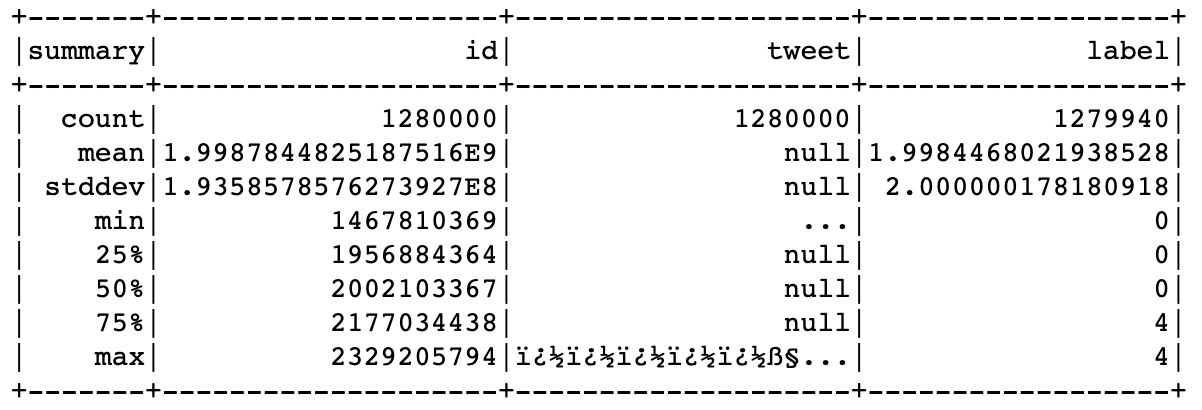

## 3. Objective/Hypothesis of the Analysis

1. The main purpose of this investigation is to perform twitter sentimental analysis to understand user's feelings with regrds to a discussed topic or product.
2. The aim is to help the companies understand how their customers feel about their services so that they can start improving where they are lacking.
3. The final end goal of this project is to train a model and do prediction using supervised learning algorithms. That way we will see how good is our analysis for use in the real world.
4. At the end , the accuracy of the trained model will be calculated and presented in percentages with 100% showing good results, 50% showing average results and below 50% will be bad results.

## 4. TECHNICAL PART - Planned Analysis

This section presents the technical analysis of the investigation. The first part will be to import all the required pyspark and MLlib modules or libraries.create a spark session and read the data stored in the HDFS cluster. the data is stored as trainB, trainB1 and testB1.Exploratory Data Analysis (EDA) will be perfomed and will be checked for null values and cleaned using functions to clean it. Data pipeline to clean, tokenize and vectorize the data will be created. then machine learning algorithms such as logistic regression will be used to train the model. then a prediction will be done on the 20% component of the data as validation. then the test data will be used as unseen data tyo make predictions.

## 4.1. Import Modules and Create Spark Session

In [1]:
# import the required libraries to be able to run some algorithms etc.
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from textblob import TextBlob
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, IDF
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import re
import string
from pyspark.ml import Pipeline
from pyspark.sql.functions import pandas_udf,udf
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.linalg import DenseVector,SparseVector
from pyspark import keyword_only  
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable  
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.classification import LinearSVC


## 4.2. Create Spark Session

In [2]:
# create and start the spark session
spark = SparkSession.builder \
    .master ("local")\
    .appName("Twitter Sentimental Analysis in Spark - Big Data") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/20 11:43:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#sc = pyspark.SparkContext()

In [5]:
# Checking the version of the pyspark being used
print('PySpark Version : ',spark.version)
print('PySpark context Version : ',spark.sparkContext.version)
spark

PySpark Version :  3.3.2
PySpark context Version :  3.3.2


In [7]:
#sc._conf.getAll()

## 4.3. Read the csv Data File into Spark DataFrame

In [11]:
# read the data stored from the local computer, below it's reading it from hadoop file system on the cluster.
df_tweets = spark.read.csv('trainB1.csv', inferSchema = True, header = True) 

In [12]:
#sql = pyspark.sql.SQLContext(sc)

In [13]:
#df = sql.read.option("header", "true").csv("hdfs://lena-master/user/nmang001/CW2_Submission/trainB1.csv")

## 4.4. Explotory Data Analysis or Preparing the Data

In [14]:
# Lets now have a view of the data
df_tweets.show(5)

+----------+--------------------+-----+
|        id|               tweet|label|
+----------+--------------------+-----+
|2051457557|@jbtaylor WIth ya...|    4|
|2053083567|felt the earthqua...|    4|
|1976779404|Ruffles on shirts...|    4|
|2325739990|Pretty bad night ...|    0|
|1973503391|@dcbriccetti yeah...|    4|
+----------+--------------------+-----+
only showing top 5 rows



In [15]:
#Display the schema and confirm if the collumns are nullable.
df_tweets.printSchema()

root
 |-- id: long (nullable = true)
 |-- tweet: string (nullable = true)
 |-- label: integer (nullable = true)



In [16]:
# Check the summary statistics of the train data set only. the data has been divided into train and test data set.
df_tweets.summary().show()

+-------+--------------------+--------------------+------------------+
|summary|                  id|               tweet|             label|
+-------+--------------------+--------------------+------------------+
|  count|             1280000|             1280000|           1279940|
|   mean|1.9987844825187516E9|                null|1.9984468021938528|
| stddev|1.9358578576273927E8|                null| 2.000000178180918|
|    min|          1467810369|                 ...|                 0|
|    25%|          1956884364|                null|                 0|
|    50%|          2002103367|                null|                 0|
|    75%|          2177034438|                null|                 4|
|    max|          2329205794|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|                 4|
+-------+--------------------+--------------------+------------------+



In [17]:
# start cleaning the data by checking if there are null values.
from pyspark.sql.functions import col,isnan, when, count
df_tweets.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_tweets.columns]
   ).show()

+---+-----+-----+
| id|tweet|label|
+---+-----+-----+
|  0|    0|   60|
+---+-----+-----+



## Null Values Critical Analysis

The results from above indicates that there are null values on the label column and there are 60 of them. Since we have only 60 out of over a million rows, the percentage number of null values is very small, approximately 0.0047%, which is insignificant and very close to nothing. Therefore, the rows with null values will be dropped in this case.

In [18]:
# Built in Function to drop the rows with null values.
df = df_tweets.dropna()

In [19]:
# verify if the null values are indeed deleted.
df.filter("label is NULL").count()

0

In [20]:
# verify if the null values are no longer there in all columns.
df.filter("label is NULL").show()

+---+-----+-----+
| id|tweet|label|
+---+-----+-----+
+---+-----+-----+



### Write re-usable functions to clean the data

Functions were created to make sure that a repeatation of steps is avoided and a good programming practice is employed to reuse the functions in the Analysis. There area a number of functions utilized such as cleaning data, Tokenization and stopwords removal. 

In [21]:
# Function to clean the data first
""" this function is used to clean the text by taking in the the raw messages
    and convert the text to lower case, then remove unwantedd characters or punctuations
    then returns the cleaned data."""
class CleanMsg(Transformer):
    def __init__(self, inputCol=None, outputCol=None):
        super(CleanMsg, self).__init__()
        self.inp=inputCol
        self.out=outputCol
    def _transform(self, dataset: DataFrame) -> DataFrame:
        col_proc=dataset[self.inp]
        @pandas_udf("string")
        def applying(col):
            def square(s):
                s=s.lower()
                for character in string.punctuation:
                    s = s.replace(character, '')
                s=re.sub(r'[\d]', '', s)
                s=re.sub(r'[\s]{2,}', ' ', s)
                s=s.strip()
                return s
            new_col=col.apply(square)
            return new_col
        
        cole=applying(col_proc)
        cleaned=dataset.select([cole.alias(self.out),dataset.label.alias("label")] )

        return cleaned

In [22]:
"""This one below is selecting the features and converting the output to arrays"""

'This one below is selecting the features and converting the output to arrays'

In [23]:
 class Selecting(Transformer):
    def __init__(self, cols=None):
        super(Selecting, self).__init__()
        self.cols=cols
    def _transform(self, dataset: DataFrame) -> DataFrame:
        dataset = dataset.withColumn('features', vector_to_array('entfidf'))
        dataset=dataset.select(self.cols)
        return dataset

## Data Pipeline

In [24]:
"""data pipeline to clean, tokenize, vectorize and select the final columns to be displayed later."""
cleanText =CleanMsg("tweet","clean_tweet")
tokenize = Tokenizer(inputCol="clean_tweet",outputCol="words")
vectorize = HashingTF(inputCol="words", outputCol="vectorized", numFeatures=20)
idf = IDF(inputCol="vectorized", outputCol="entfidf")
choose=Selecting(cols=["features","label"])
pipeline = Pipeline(stages=[cleanText,tokenize,vectorize,idf,choose])
model = pipeline.fit(df)

In [25]:
# Cleaned data transformed as shown below.
cleaned_data = model.transform(df)

In [26]:
# displaying the final cleaned data
cleaned_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.86812247869667...|    4|
|[0.0, 0.0, 2.4441...|    4|
|[0.0, 0.0, 0.0, 1...|    4|
|[0.86812247869667...|    0|
|[0.0, 0.0, 0.0, 0...|    4|
+--------------------+-----+
only showing top 5 rows



### Converting features column from array type to vector type so we can use pyspark ml algorithms

In [27]:
from pyspark.ml.linalg import Vectors, VectorUDT
func=udf(lambda vs: Vectors.dense(vs), VectorUDT())

In [28]:
data=cleaned_data.withColumn("vectors",func(cleaned_data["features"]))
data=data.select(["vectors",data["label"].cast(FloatType()) ])

In [29]:
data.show(5)

23/03/20 11:55:14 WARN ArrowPythonRunner: Detected deadlock while completing task 0.0 in stage 15 (TID 12): Attempting to kill Python Worker
+--------------------+-----+
|             vectors|label|
+--------------------+-----+
|[0.86812247869667...|  4.0|
|[0.0,0.0,2.444186...|  4.0|
|[0.0,0.0,0.0,1.78...|  4.0|
|[0.86812247869667...|  0.0|
|[0.0,0.0,0.0,0.0,...|  4.0|
+--------------------+-----+
only showing top 5 rows



# 5. Building the Models

### 5.1. Spliting the data into Training set and Validation (test) set

In [30]:
# Split the data into 80% training set and 20% testing set
SplitData = data.randomSplit([0.7, 0.3])
TrainSet = SplitData[0]
TestSet = SplitData[1]
trainRows = TrainSet.count()
testRows = TestSet.count()
print(trainRows, testRows)

896086 383854


### 5.2. train the model using Logistice Regression

In [31]:
lr = LogisticRegression(labelCol="label", featuresCol="vectors", maxIter=10, regParam=0.01)
model = lr.fit(TrainSet)

23/03/20 11:56:45 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


23/03/20 11:57:10 WARN MemoryStore: Not enough space to cache rdd_120_0 in memory! (computed 65.0 MiB so far)
23/03/20 11:57:10 WARN BlockManager: Persisting block rdd_120_0 to disk instead.
23/03/20 11:57:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/20 11:57:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [32]:
# predict the labels 
prediction = model.transform(TestSet)

In [33]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
evaluator.evaluate(prediction)

0.5725872584280409

In [34]:
predictionFinal = prediction.select("label", "prediction")
#predictionFinal.show(5)
correctPred = predictionFinal.filter(predictionFinal['prediction']==predictionFinal['label']).count()
totalData = predictionFinal.count()
print(correctPred, totalData, ", accuracy:",correctPred/totalData )

220178 383854 , accuracy: 0.5735982951851485


## Critical Analysis of the accuracy of the Logistic Regression trained model.

The results above provides the accuracy of 57% which is an average and not the best results for this model. Theses results were produced using MLlib logistic Regression classifier. Below we will investigate other MLlib classifiers to compare the results.

### 5.3. train the model using NaiveBayes

In [74]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="label", featuresCol="vectors", smoothing=1,modelType="multinomial")
model2 = nb.fit(TrainSet)

In [75]:
# predict the labels 
prediction = model2.transform(TestSet)

In [76]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
evaluator.evaluate(prediction)

0.28514562916783925

In [77]:
predictionFinal2 = prediction.select("label", "prediction")
predictionFinal2.show(5)
correctPred = predictionFinal2.filter(predictionFinal2['prediction']==predictionFinal2['label']).count()
totalData = predictionFinal2.count()
print(correctPred, totalData, ", accuracy:",correctPred/totalData )

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



108903 383529 , accuracy: 0.28394984473142837


## Critical Analysis of the accuracy of the Naive Bayes Regression trained model.

The results above provides the accuracy of 29% which is below average and is regarded as bad results for this model. Theses results were produced using MLlib NaiveBayes classifier. Below we will investigate other MLlib classifiers to compare the results.

### 5.4. train the model using RandomForestClassifier

In [78]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=4, maxDepth=5, seed=42, labelCol="label", featuresCol="vectors")
model3 = rf.fit(TrainSet)

23/03/18 18:03:07 WARN MemoryStore: Not enough space to cache rdd_453_0 in memory! (computed 61.6 MiB so far)
23/03/18 18:03:07 WARN BlockManager: Persisting block rdd_453_0 to disk instead.


In [79]:
# predict the labels 
prediction = model3.transform(TestSet)

In [80]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
evaluator.evaluate(prediction)

0.5653462143026102

In [82]:
predictionFinal3 = prediction.select("label", "prediction")
#predictionFinal3.show(5)
correctPred = predictionFinal3.filter(predictionFinal3['prediction']==predictionFinal3['label']).count()
totalData = predictionFinal3.count()
print(correctPred, totalData, ", accuracy:",correctPred/totalData )

216828 383529 , accuracy: 0.5653496867251238


## Critical Analysis of the accuracy of the Random Forest Classifier .

The results above provides the accuracy of 56% which is slightly above average and is regarded as bad results for this model. Theses results were produced using MLlib Random forest classifier. 


## 5.5. Unseen Test Data predictions

Now the predictions will be done on unseen test data using the best perfomed model, which is the Logistic regression in this case.The test dataset does not have labels now. The test dataset will also be cleaned using the same procedure for the train datset. then prediction will be made but this time we won't be able to see the accuracy score. on satisfation, the model can be packaged to be used in real life company situations.

In [35]:
# read the dataset from the HDFS storage cluster
df_test = spark.read.csv('testB1.csv', inferSchema = True, header = True)

In [36]:
df_test.show(5)

+----------+--------------------+
|        id|               tweet|
+----------+--------------------+
|2200003196|@chrishasboobs AH...|
|1467998485|@misstoriblack co...|
|2300048954|@TiannaChaos i kn...|
|1993474027|School email won'...|
|2256550904|upper airways pro...|
+----------+--------------------+
only showing top 5 rows



In [37]:
df_test = df_test.withColumnRenamed("tweet","message")

In [38]:
df_test.show(5)

+----------+--------------------+
|        id|             message|
+----------+--------------------+
|2200003196|@chrishasboobs AH...|
|1467998485|@misstoriblack co...|
|2300048954|@TiannaChaos i kn...|
|1993474027|School email won'...|
|2256550904|upper airways pro...|
+----------+--------------------+
only showing top 5 rows



In [39]:
# lets check for null values on the test data set now.
df_test.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_test.columns]
   ).show()

+---+-------+
| id|message|
+---+-------+
|  0|      0|
+---+-------+



In [86]:
 #Function to clean the test data first
class CleanText(Transformer):
    def __init__(self, inputCol=None, outputCol=None):
        super(CleanText, self).__init__()
        self.inp=inputCol
        self.out=outputCol
    def _transform(self, dataset: DataFrame) -> DataFrame:
        col_proc=dataset[self.inp]
        @pandas_udf("string")
        def applying(col):
            def square(s):
                s=s.lower()
                for character in string.punctuation:
                    s = s.replace(character, '')
                s=re.sub(r'[\d]', '', s)
                s=re.sub(r'[\s]{2,}', ' ', s)
                s=s.strip()
                return s
            new_col=col.apply(square)
            return new_col
        
        cole=applying(col_proc)
        cleaned=dataset.select([cole.alias(self.out), dataset.id.alias("id")] )

        return cleaned

In [87]:
class Selecting(Transformer):
    def __init__(self, cols=None):
        super(Selecting, self).__init__()
        self.cols=cols
    def _transform(self, dataset: DataFrame) -> DataFrame:
        dataset = dataset.withColumn('features', vector_to_array('entfidf'))
        dataset=dataset.select(self.cols)
        return dataset

In [89]:
clean=CleanText("tweet","tweet_cleans")
tokenizer = Tokenizer(inputCol="tweet_cleans",outputCol="words")
vectorizer = HashingTF(inputCol="words", outputCol="vectorized", numFeatures=20)
idf = IDF(inputCol="vectorized", outputCol="entfidf")
select=Selecting(cols=["features", "id"])
pipeline = Pipeline(stages=[clean,tokenizer,vectorizer,idf,select])
model = pipeline.fit(df_test)

In [90]:
cleaned_data = model.transform(df_test)

In [91]:
cleaned_data.show(5)

+--------------------+----------+
|            features|        id|
+--------------------+----------+
|[0.86381259651779...|2200003196|
|[0.0, 0.0, 0.0, 0...|1467998485|
|[0.86381259651779...|2300048954|
|[0.86381259651779...|1993474027|
|[0.0, 0.0, 0.0, 0...|2256550904|
+--------------------+----------+
only showing top 5 rows



In [94]:
test_data=cleaned_data.withColumn("vectors",func(cleaned_data["features"]))
test_data=test_data.select(["vectors",test_data["id"]])

In [95]:
test_data.show(5)

23/03/18 18:16:41 WARN ArrowPythonRunner: Detected deadlock while completing task 0.0 in stage 120 (TID 102): Attempting to kill Python Worker
+--------------------+----------+
|             vectors|        id|
+--------------------+----------+
|[0.86381259651779...|2200003196|
|[0.0,0.0,0.0,0.0,...|1467998485|
|[0.86381259651779...|2300048954|
|[0.86381259651779...|1993474027|
|[0.0,0.0,0.0,0.0,...|2256550904|
+--------------------+----------+
only showing top 5 rows



In [96]:
lr = LogisticRegression(labelCol="label", featuresCol="vectors", maxIter=10, regParam=0.01)
model = lr.fit(TrainSet)

23/03/18 18:18:05 WARN MemoryStore: Not enough space to cache rdd_641_0 in memory! (computed 65.0 MiB so far)
23/03/18 18:18:05 WARN BlockManager: Persisting block rdd_641_0 to disk instead.


In [97]:
# predict the labels 
predictionT = model.transform(test_data)

In [98]:
#Final prediction on unseen data using the best MLlib logistic regression
Results = predictionT.select("id", "prediction")
Results.show(10)

23/03/18 18:19:35 WARN ArrowPythonRunner: Detected deadlock while completing task 0.0 in stage 134 (TID 116): Attempting to kill Python Worker
+----------+----------+
|        id|prediction|
+----------+----------+
|2200003196|       4.0|
|1467998485|       0.0|
|2300048954|       0.0|
|1993474027|       0.0|
|2256550904|       4.0|
|2052380495|       0.0|
|1983449090|       0.0|
|2245479748|       4.0|
|1770705699|       4.0|
|1970386589|       4.0|
+----------+----------+
only showing top 10 rows



## Save the prediction in a csv file on HDFS storage cluster.

In [101]:
Final_pred = Results.write.csv('Final_pred.csv')

In [40]:
spark.stop()

## 6. Summary and Conclusion

A twitter sentimental analysis was conducted using dataset on kaggle. The technical part of the project was implemented on hadoop cluster to demostrate big data processing with pyspark and spark MLlib. Exploratory data analysis was conducted using libraries and data pipeline to achieve the results obtained. Finally spark MLlib algorithms were used to train the model. three classifier algorthms were utilzed to train the model, those classifier are Logistic regression, Naive bayes classifier and random forest classifier.

If one look at the results of these Mllib algorithms, in almost all of them the results are not that good with Naive Bayes being the worst, with an accuracy of 28%, while Logistic regressiona and random forest presents similar results of 57%.It is clear from the results that there is a need for improvements. Future work needs to be done to improve the results maybe looking at the data set again, try to balance the imbalanced data, and other parameters that can be used to improve the accuracy before it is used in the real company world.


## References

[1] Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.


Course web notes, https://learn.london.ac.uk/course/view.php?id=1347, Accessed from October 2022 to March 2023

Pyspark tutorials website, https://sparkbyexamples.com/pyspark-tutorial/, Accessed from January 2023 to March 2023
